In [1]:
# theory: https://www.youtube.com/watch?v=ERibwqs9p38 stanford lectures about NLP

# algorithms: 
# SG - Skip grams (predit context based on word)
# CBOW - Countinous bag of words (predict word based on context)

# I will use it to create vectors (or use SVD or GloVe)
# Do pca to draw a graph
# Pick a few words for each emotion
# Mark them on chart and pick surrouding words
# The more close it is the bigger weight has

# And then I have more emotionaly sensed words for classification 
# from which I can label each comment
# And train model to classify comment based on TF*ITF

# practice: 

# Emotions and corresponding words

In [2]:
# Articles about terrorism or murder
rage = ['nienawidze', 'zabic', 'zniszczyc', 'nienawisc', 'denerwuje']
# Goverment changes something to bettter
joy = ['dziekuje', 'swietnie', 'ciesze', 'super']
# Tragedy
sadness = ['dolujace', 'smutne', 'szkoda', 'zaluje']
# Celebretities gossips
surprise = ['zaskoczylo', 'dziwne', 'niesamowite', 'zaskakujace', 'ciekawe']
# Scary news
fear = ['boje', 'strach', 'straszne']

all_flag_words = rage + joy + sadness + surprise + fear 

## SVD
https://www.youtube.com/watch?v=ASn7ExxLZws

### Data (matrix) preparation

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
df = pd.read_csv('processed_comments_1.csv', nrows = 2000)[['words']]

In [6]:
df = df[df['words'].str.contains(r'|'.join(all_flag_words))]

In [7]:
words_dict_counter = {}
step = 3

for comment in df['words']:
    listed_comment = eval(comment)
    contains_word_flag = False

    for i, word in enumerate(listed_comment):

        if word not in words_dict_counter.keys():
            words_dict_counter[word] = {}

        if i-step < 0:
            first_index = 0
            to_delete = i
        else:
            first_index = i-step
            to_delete = step

        corresponding_words = listed_comment[first_index: i+step+1]
        del corresponding_words[to_delete]

        for corresponding_word in corresponding_words:
            if corresponding_word not in words_dict_counter[word].keys():
                words_dict_counter[word][corresponding_word] = 1
            else:
                words_dict_counter[word][corresponding_word] += 1

In [8]:
word_order = words_dict_counter.keys()

In [9]:
words_to_stay_in_matrix = []
for needed_word in all_flag_words:
    if needed_word in words_dict_counter.keys():
        words_to_stay_in_matrix.append(needed_word)
        for found_word in words_dict_counter[needed_word]:
            words_to_stay_in_matrix.append(found_word)

In [10]:
matrix = []
for i, ordered_word_i in enumerate(words_to_stay_in_matrix):
    proximity = words_dict_counter[ordered_word_i]
    ordered_row = []
    for j, ordered_word_j in enumerate(words_to_stay_in_matrix):
        if i == j:
            ordered_row.append(0)
            continue
        if ordered_word_j in proximity.keys():
            ordered_row.append(proximity[ordered_word_j])
        else:
            ordered_row.append(0)
    matrix.append(ordered_row)

In [11]:
word_matrix = np.array(matrix).astype('float32')

In [12]:
word_matrix.shape

(348, 348)

### SVD evaluation

In [13]:
import matplotlib.pyplot as plt

In [14]:
U, s, V = np.linalg.svd(word_matrix, full_matrices=False)

In [15]:
U.shape

(348, 348)

[-0.5, 0.5, -0.5, 0.5]

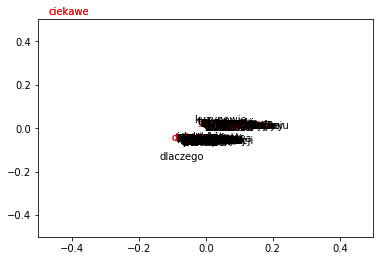

In [16]:
a = 0.5
for i, word in enumerate(words_to_stay_in_matrix):
    if word in all_flag_words:
        plt.text(U[i, 0], U[i, 1], word, color='r')
    else:
        plt.text(U[i, 0], U[i, 1], word)
plt.axis([-a, a, -a, a])

Having so many comments it is not possible for me to make it work for whole dataset, and it seems that it won't give me a good results. Let's try another ones.

## Word2Vec

https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac


In [17]:
import tensorflow as tf

### Data (pairs) preparation

In [18]:
from random import shuffle

In [19]:
pairs = []
words = []
for middle_word, proximity in words_dict_counter.items():
    words.append(middle_word)
    for proximity_word, num_of_occurences in proximity.items():
        words.append(proximity_word)
        for i in range(num_of_occurences):
            pairs.append([proximity_word, middle_word])

In [20]:
shuffle(pairs) # to shuffle duplicates

In [21]:
pairs[:10]

[['sygnalu', 'ludzie'],
 ['rozpoznawaniu', 'polsce'],
 ['antyutleniaczem', 'niezbedna'],
 ['jest', 'nieladnie'],
 ['nowoscia', 'wiec'],
 ['przecietny', 'czasu'],
 ['dolinie', 'morawiecki'],
 ['o', 'r'],
 ['woli', 'znicz'],
 ['procesy', 'placimy']]

In [22]:
word2int = {}
int2word = {}
for i,word in enumerate(list(set(words))):
    word2int[word] = i
    int2word[i] = word

In [23]:
vocab_size = len(set(words))

In [24]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [25]:
x_train = [] 
y_train = [] 

In [26]:
for pair in pairs:
    x_train.append(to_one_hot(word2int[ pair[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ pair[1] ], vocab_size))

In [27]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [28]:
print(x_train.shape, y_train.shape)

(14252, 2049) (14252, 2049)


In [29]:
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

In [30]:
EMBEDDING_DIM = step

In [31]:
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))
hidden_representation = tf.add(tf.matmul(x,W1), b1)

In [32]:
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

In [33]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [34]:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

In [35]:
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy_loss)

In [36]:
n_iters = 1000

In [37]:
for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    #print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

In [38]:
vectors = sess.run(W1 + b1)

In [39]:
from sklearn.manifold import TSNE

In [40]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [41]:
from sklearn import preprocessing

In [42]:
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

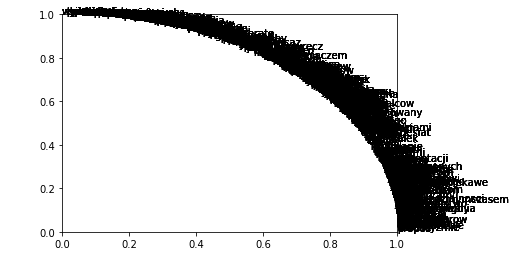

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for word in words:
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()

## GloVe

## Pick a few emotion words and their proimity from models

## Assign labels to comments